#ResNet (Residual Network)

Mạng ResNet (R) là một mạng CNN được thiết kế để làm việc với hàng trăm hoặc hàng nghìn lớp chập. Một vấn đề xảy ra khi xây dựng mạng CNN với nhiều lớp chập sẽ xảy ra hiện tượng **Vanishing Gradient** dẫn tới quá trình học tập không tốt.

Hiệu quả khi train các network cực kì sâu

**Kiến trúc mạng Resnet**

ResNet đưa ra là sử dụng kết nối "tắt" đồng nhất để xuyên qua một hay nhiều lớp. Một khối như vậy được gọi là một Residual Block.

![Resnet](https://images.viblo.asia/9fc720ba-45e4-4d2f-8b58-5926350bc075.png)

**ResNet** gần như tương tự với các mạng gồm có convolution, pooling, activation và fully-connected layer. Ảnh bên trên hiển thị khối dư được sử dụng trong mạng.
- F(X) = *X->weight1->RLU->weight2* là giá trị thật(nhãn)
- H(X) = *F(X)+x->ReLU*, là giá trị dự đoán

Như chúng ta đã biết việc tăng số lượng các lớp trong mạng làm giảm độ chính xác, nhưng muốn có một kiến trúc mạng sâu hơn có thể hoạt động tốt.

![Image](https://www.researchgate.net/profile/Xiao-Wang-160/publication/330553565/figure/fig9/AS:718079331930112@1548214862864/Architecture-of-VGG-19-34-layer-plain-and-Residual-Network34-for-ImageNet.ppm)

- VGG-19 là một mô hình CNN sử dụng kernel 3x3 trên toàn bộ mạng.
- ResNet sử dụng các kết nối tắt ( kết nối trực tiếp đầu vào của lớp (n) với (n+x) được hiển thị dạng mũi tên cong. Qua mô hình nó chứng minh được có thể cải thiện hiệu suất trong quá trình training model khi mô hình có hơn 20 lớp.
- Tổng cộng có 12 đầu ra từ ResNet-152 và VGG-19 đã được sử dụng làm đầu vào cho mạng có 2 lớp hidden. Đầu ra cuối cùng được tính toán thông qua hai lớp ẩn ( hidden).

**Xây dựng mạng ResNet-50**

![Noron ResNet](https://images.viblo.asia/fe5b21e5-3ad3-4419-93e0-7aa77a662bdd.png)

"ID BLOCK" trong hình trên là viết tắt của từ Identity block và ID BLOCK x3 nghĩa là có 3 khối Identity block chồng lên nhau. Nội dung hình trên như sau :

- Zero-padding : Input với (3,3)
- Stage 1 : Tích chập (Conv1) với 64 filters với shape(7,7), sử dụng stride (2,2). BatchNorm, MaxPooling (3,3).
- Stage 2 : Convolutiontal block sử dụng 3 filter với size 64x64x256, f=3, s=1. Có 2 Identity blocks với filter size 64x64x256, f=3.
- Stage 3 : Convolutional sử dụng 3 filter size 128x128x512, f=3,s=2. Có 3 Identity blocks với filter size 128x128x512, f=3.
- Stage 4 : Convolutional sử dụng 3 filter size 256x256x1024, f=3,s=2. Có 5 Identity blocks với filter size 256x256x1024, f=3.
- Stage 5 :Convolutional sử dụng 3 filter size 512x512x2048, f=3,s=2. Có 2 Identity blocks với filter size 512x512x2048, f=3.
- The 2D Average Pooling : sử dụng với kích thước (2,2).
The Flatten.
- Fully Connected (Dense) : sử dụng softmax activation.

**ID Block**

Here is identity block:

![Identiy](https://i.stack.imgur.com/37qzA.png)

and here is convolutional block:

![cblock](https://i.stack.imgur.com/0mE2p.png)





**Batch Nomalization**

Input: Values of $x$ over a mini-batch: $B = \{x_{1}...m\}$ Parameters to be learned: $\gamma,\beta$

Output: $\{ y_{i} = BN_{\gamma,\beta} (x_{i})\}$

$\mu_{B} \leftarrow \frac{1}{m} \sum _{i=1}^{m} x_{i}  //mini -bacthmean$

$\sigma_{B}^{2} \leftarrow \frac{1}{m} \sum _{i=1}^{m} (x_{i} - \mu_{B})^{2} //mini - batchvariance$

$\widehat{x}_{i} \leftarrow \frac{x_{i} - \mu_{B}}{\sqrt{\sigma^{2}_{B} + \epsilon}} //normalize$

$y_{i} \leftarrow \gamma \widehat{x}_{i} + \beta \equiv BN_{\gamma, \beta}(x_{i}) \text{\\\scale and shift}$

- Đặt trước activation
- Kéo ra khỏi điểm bão hòa (vanishing)
- Giúp đầu vào ổn định, dù data thay đổi nhiều
> Đạo hàm tốt hơn. Đạo hàm có cả *x* không chỉ có weight trong đấy thì *x* ổn định => output ổn đinh.
- Tránh overfiting.
- lúc training bắt buộc batch size > 1 (vì nếu là 1 nó là chính nó x hat = 0)
- batch nom có weight có training, nhưng không dùng gradient để tối ưu.

In [ ]:
import numpy as np

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum, is_training):
    # Use `autograd` to determine whether the current mode is training mode or
    # prediction mode
    if not is_training:
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)# for debugging
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(axis=0)
            var = ((X - mean)**2).mean(axis=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean)**2).mean(axis=(0, 2, 3), keepdims=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / np.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean, moving_var

In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow


In [ ]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

Mounted at /content/drive


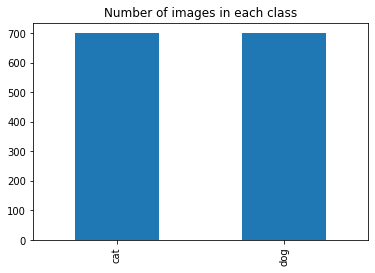

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive")
path = '/content/drive/MyDrive/Colab Notebooks/Data'
os.chdir(path)
os.listdir()

import pandas as pd
import glob2
import matplotlib.pyplot as plt

dogs = glob2.glob('Train_Data/dog/*.jpg')
dog_labels = ['dog']*len(dogs)
cats = glob2.glob('Train_Data/cat/*.jpg')
cat_labels = ['cat']*len(cats)

labels = dog_labels + cat_labels
image_links = dogs + cats

data = pd.DataFrame({'labels': labels, 'image_links':image_links})

data.groupby(labels).image_links.count().plot.bar()
plt.title('Number of images in each class')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
Y = LabelBinarizer().fit_transform(data.labels)

X=[]
for link in data[0:10].image_links:
  # load an image from file
  image = load_img(link, target_size=(224, 224))
  # convert the image pixels to a numpy array
  image = img_to_array(image)
  # reshape data for the model
  image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
  # prepare the image for the VGG model
  image = preprocess_input(image)
  X.append(image)

X=np.asarray(X)

print(X.shape)


(10, 224, 224, 3)


In [ ]:
from keras.utils.np_utils import to_categorical
Y = to_categorical(Y)

X_test=X[5:]
Y_test=Y[5:]

X_train=X[0:5]
Y_train=Y[0:5]

print(X_test.shape, Y_test.shape, X_train.shape,Y_train.shape)

(5, 224, 224, 3) (1394, 2) (5, 224, 224, 3) (5, 2)


In [ ]:
modelRN = ResNet50(input_shape=(224,224,3),classes=2)
modelRN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
modelRN.fit(x=X_train,y=Y_train,epochs=3,batch_size = 32)

Epoch 1/3
1/1 [==============================] - 21s 21s/step - loss: 1.2080 - accuracy: 0.2000
Epoch 2/3
1/1 [==============================] - 3s 3s/step - loss: 5.2863e-18 - accuracy: 1.0000
Epoch 3/3
1/1 [==============================] - 3s 3s/step - loss: 3.2014e-24 - accuracy: 1.0000
